In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.signal as signal
from scipy import cluster
from Bio import SeqIO
from Bio.Seq import Seq, MutableSeq 
from Bio.SeqUtils import GC  
import random
from SCvariables import *
%matplotlib inline

sns.set_style('white')
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [2]:
genome_folder = './data/scer/'
genomefasta = {}
for i in range(1,10):
    x = loading_fasta_gbk(genome_folder + 'chr0{}.fsa'.format(i),'fasta')
    genomefasta[x.name] = x
for i in range(10,17):
    x = loading_fasta_gbk(genome_folder + 'chr{}.fsa'.format(i),'fasta')
    genomefasta[x.name] = x

chr_lengths = pd.read_csv(genome_folder + 'scer.genome',sep = '\t',header=None)
chr_lengths.columns = ['chromosome','length']

yeastgenome = {}
chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
for i in range(1,10):
    x = loading_fasta_gbk(genome_folder + 'chr0{}.gb'.format(i),'genbank')
    yeastgenome['chr'+chroms[i-1]] = reading_gbk_new(x,['CDS','tRNA','rRNA','ncRNA'])
for i in range(10,17):
    x = loading_fasta_gbk(genome_folder + 'chr{}.gb'.format(i),'genbank')
    yeastgenome['chr'+chroms[i-1]] = reading_gbk_new(x,['CDS','tRNA','rRNA','ncRNA'])


##yeastgenome representation puts a 1 where there is a gene
yeastgenome_gene_representation = {}
for key, val in iter(yeastgenome.items()):
    x = np.zeros([1,len(genomefasta[key].seq)])
    for genes in [val]:
        for i in range (0, len(genes.annotation)):
            if genes.strand[i]== +1:
                for j in range(0, genes.length[i]-1):
                    x[0][genes.start[i]+j]=10
            else:
                for j in range(0,genes.length[i]-1):
                    x[0][genes.end[i]+j]=-10
    yeastgenome_gene_representation[key] = x
    
#convert into a pandas...
genomedict = {}
chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
for c in chroms:
    chrom = 'chr'+c
    name,start,end,strand=[],[],[],[]
    for j in range(len(yeastgenome[chrom].start)):
        name.append(yeastgenome[chrom].name[j])
        start.append(yeastgenome[chrom].start[j])
        end.append(yeastgenome[chrom].end[j])
        strand.append(yeastgenome[chrom].strand[j])
    genomedict[chrom] = pd.DataFrame([name,start,end,strand],['name','start','end','strand']).transpose()
    
#calculate AT content
sliding_100 = {}
for key, val in iter(genomefasta.items()):
    sliding_100[key] = sliding_window(val,100)[0]
    
genomedict = formatGenomeDict(genomedict,genomefasta)

catyeastgenome = genomefasta['chrI'].seq
for chrom in chroms[1:]:
    catyeastgenome = catyeastgenome + genomefasta['chr'+chrom].seq

In [3]:
RNAseq = loadyeastRNAseqData() #raff data
RNAseqaF = loadyeastRNAseqaFData() #aF arrest data
RNAseq_RPKM = pd.read_csv('./data/RNAseq_rpkm_merged.txt',sep=',')

downloading GSM5001907_D20-252008_nodup_plus_all.txt.gz from GEO
unzipping GSM5001907_D20-252008_nodup_plus_all.txt.gz


/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


downloading GSM5001907_D20-252008_nodup_minus_all.txt.gz from GEO
unzipping GSM5001907_D20-252008_nodup_minus_all.txt.gz
downloading GSM5001909_D20-252007_nodup_plus_all.txt.gz from GEO
unzipping GSM5001909_D20-252007_nodup_plus_all.txt.gz
downloading GSM5001909_D20-252007_nodup_minus_all.txt.gz from GEO
unzipping GSM5001909_D20-252007_nodup_minus_all.txt.gz


In [4]:
GapR_raff = loadraffChIP()
GapR_raffneg = loadraffnegChIP()
chip_fold = loadChIPFold(GapR_raff, GapR_raffneg)

downloading GSM5001899_D20-5952_all_nodup.txt.gz from GEO
unzipping GSM5001899_D20-5952_all_nodup.txt.gz
downloading GSM5001905_D20-261001_all_nodup.txt.gz from GEO
unzipping GSM5001905_D20-261001_all_nodup.txt.gz


In [5]:
GapR_raffaF = loadraffaFChIP()
GapR_raffnegaF = loadaFnegChIP()
chip_foldaF = loadChIPFold(GapR_raffaF, GapR_raffnegaF)

downloading GSM5001901_D20-5954_all_nodup.txt.gz from GEO
unzipping GSM5001901_D20-5954_all_nodup.txt.gz
downloading GSM5001906_D20-261002_all_nodup.txt.gz from GEO
unzipping GSM5001906_D20-261002_all_nodup.txt.gz


In [6]:
#MNase Data
mnase = downloadMNase()

#DNase Data -- generated from mapping fastq files from GSM1705337
DNase_Zhong_pl = pd.read_csv('./data/SRR2056071_DNase_plus_all.txt',sep=',',index_col=0)
DNase_Zhong_min = pd.read_csv('./data/SRR2056071_DNase_minus_all.txt',sep=',',index_col=0)
DNase_Zhong_pl['both'] = DNase_Zhong_pl.value+DNase_Zhong_min.value
DNase_Zhong_pl['log10'] = np.log10(DNase_Zhong_pl.both+1)

downloading GSM3069971_MNase_YPD30_WT-B_166_40U.sgr.gz from GEO
unzipping GSM3069971_MNase_YPD30_WT-B_166_40U.sgr.gz


In [7]:
#Psoralen Data in Glucose -- generated from bedgraph files from GSM3141352
psoralenG128 = pd.read_csv('./data/GSM3141352_WT_Supercoil_G128_all_nodup.txt',sep = ',', index_col=0) #bTMP/IP

### Fig. 5A

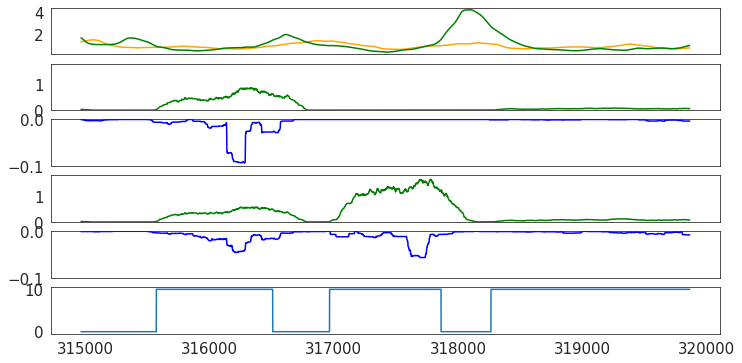

In [8]:
#FIG1 @ chrII 316968-317864
start = 316968-2000
end = 317864+2000
chrom = 'chrII'
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12,6), sharey=False)
axes[0].plot(np.arange(start, end),chip_fold[chip_fold.chr==chrom].fold_nolog[start:end], 'orange')
axes[0].plot(np.arange(start, end),chip_foldaF[chip_foldaF.chr==chrom].fold_nolog[start:end], 'green')

axes[1].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'green')
axes[2].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')

axes[1].set_ylim([0,1.8])
axes[2].set_ylim([-0.1,0])

axes[3].plot(np.arange(start, end),(RNAseqaF[RNAseqaF.chr==chrom].fwd[start:end]),'green')
axes[4].plot(np.arange(start, end),-(RNAseqaF[RNAseqaF.chr==chrom].rev[start:end]),'blue')

axes[3].set_ylim([0,1.8])
axes[4].set_ylim([-0.1,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)

axes[5].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 5B

In [9]:
RNAseq_RPKM['aF/gal'] = (RNAseq_RPKM.aF+1)/(RNAseq_RPKM.gal+1)
#RNAseq_RPKM[abs(RNAseq_RPKM.fullstart-RNAseq_RPKM.fullend) >= 1000].sort_values('aF/gal')[-5:]

In [10]:
#remove ty element genes from RNAseq list for this analysis: 

#import and parse list of ty elements
ty_list = pd.read_csv('./data/Scer3_ty.txt',sep = ' ',header=None)
ty_list.columns = ['names',1,2,3,4,'strand']
ty_list['chr'] = 'chr'+ty_list[3]
a = []
[a.append(int(str.split(i,'..')[0])) for i in ty_list[4].values]
ty_list['start'] = a
a = []
[a.append(int(str.split(i,'..')[1])) for i in ty_list[4].values]
ty_list['end'] = a
ty_list.drop(columns=[1,2,3,4],inplace=True)

#Drop YCLWTy5-1 b/c too close to chr end
ty_list.drop(19,inplace=True)

#ty start always on LEFT of ty end
noTY_RNAseq = RNAseq_RPKM.copy()

for i, val in ty_list.iterrows():
    x = RNAseq_RPKM[(RNAseq_RPKM.chr==val.chr) & (val.start < RNAseq_RPKM.start) & (val.end > RNAseq_RPKM.end)]
    drop_ty = x.index
    noTY_RNAseq = noTY_RNAseq.iloc[~noTY_RNAseq.index.isin(drop_ty.values)]

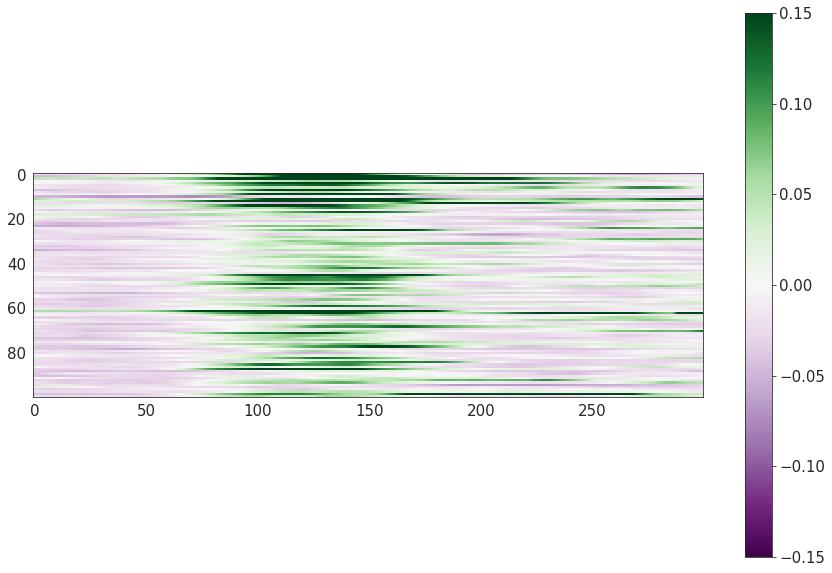

In [11]:
#genes that are up, 3pr end
chip_diff = GapR_raffaF.smooth - GapR_raff.smooth

GapEnrich = []
foldrpkM = []
ind = []
for i, j in noTY_RNAseq.iterrows():
    try:
        if (abs(j.fullstart-j.fullend) >=1000) and (j.aF > 30):
            foldrpkM.append(j[['gal','aF','aF/gal']])
            ind.append(i)
            if j.strand == 1:
                GapEnrich.append(chip_diff[j.fullend-1000:j.fullend+2000].values)
            else:
                GapEnrich.append(chip_diff[j.fullend-2000:j.fullend+1000].values[::-1])
    except:
        print(i)

binSize = 10
out = []
errs = []
for j in range(len(GapEnrich)):
    if len(GapEnrich[j]) == 3000:
        a = []
        for i in range(0,3000,binSize):
            a.append(np.mean(GapEnrich[j][i:i+10]))
        out.append(a)
    else:
        errs.append(j)
        
newMat = pd.DataFrame(foldrpkM)
for i in range(len(errs)):
    newMat = newMat.drop(foldrpkM[errs[i]].name)
newMat['thrends'] = out
newMat.sort_values('aF/gal',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)

plt.figure(figsize = [15,10])
plt.imshow(sortedGapEnrich[:100],vmin=-0.15, vmax = 0.15, cmap='PRGn') #about 3x up
plt.colorbar()

1586


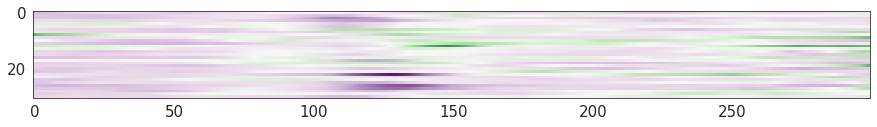

In [12]:
#genes that are down, 3pr end
chip_diff = GapR_raffaF.smooth - GapR_raff.smooth

GapEnrich = []
foldrpkM = []
ind = []
for i, j in noTY_RNAseq.iterrows():
    try:
        if (abs(j.fullstart-j.fullend) >=1000) and (j.gal > 30):
            foldrpkM.append(j[['gal','aF','aF/gal']])
            ind.append(i)
            if j.strand == 1:
                GapEnrich.append(chip_diff[j.fullend-1000:j.fullend+2000].values)
            else:
                GapEnrich.append(chip_diff[j.fullend-2000:j.fullend+1000].values[::-1])
    except:
        print(i)

binSize = 10
out = []
errs = []
for j in range(len(GapEnrich)):
    if len(GapEnrich[j]) == 3000:
        a = []
        for i in range(0,3000,binSize):
            a.append(np.mean(GapEnrich[j][i:i+10]))
        out.append(a)
    else:
        print(j)
        errs.append(j)
        
newMat = pd.DataFrame(foldrpkM)
newMat = newMat.drop(foldrpkM[errs[0]].name)
newMat['thrends'] = out
newMat.sort_values('aF/gal',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)

plt.figure(figsize = [15,10])
plt.imshow(sortedGapEnrich[-31:],vmin=-0.15, vmax = 0.15, cmap='PRGn') #about 3-fold down

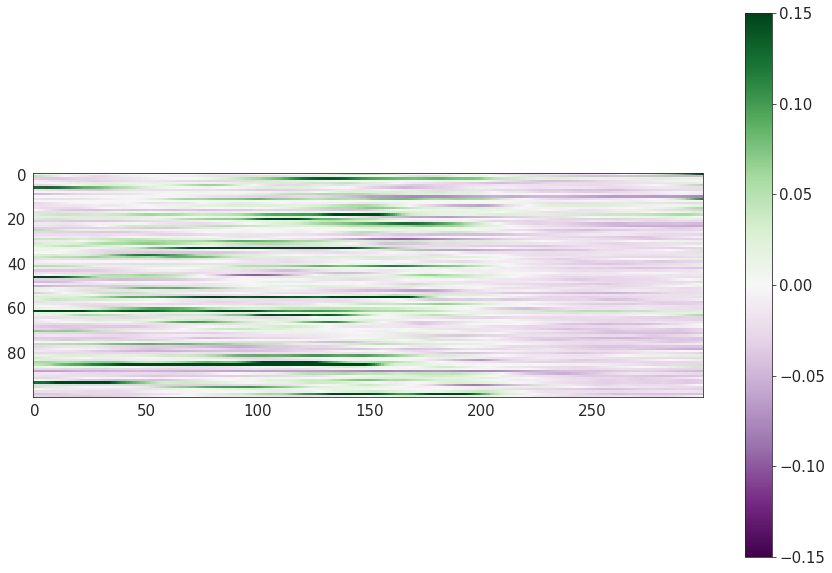

In [13]:
#genes that are up, 5pr end
chip_diff = GapR_raffaF.smooth - GapR_raff.smooth

GapEnrich = []
foldrpkM = []
ind = []
for i, j in noTY_RNAseq.iterrows():
    try:
        if (abs(j.fullstart-j.fullend) >=1000) and (j.aF > 30):
            foldrpkM.append(j[['gal','aF','aF/gal']])
            ind.append(i)
            if j.strand == 1:
                GapEnrich.append(chip_diff[j.fullstart-2000:j.fullstart+1000].values)
            else:
                GapEnrich.append(chip_diff[j.fullstart-1000:j.fullstart+2000].values[::-1])
    except:
        print(i)

binSize = 10
out = []
errs = []
for j in range(len(GapEnrich)):
    if len(GapEnrich[j]) == 3000:
        a = []
        for i in range(0,3000,binSize):
            a.append(np.mean(GapEnrich[j][i:i+10]))
        out.append(a)
    else:
        print(j)
        errs.append(j)
        
newMat = pd.DataFrame(foldrpkM)
for i in range(len(errs)):
    newMat = newMat.drop(foldrpkM[errs[i]].name)
newMat['thrends'] = out
newMat.sort_values('aF/gal',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)

plt.figure(figsize = [15,10])
plt.imshow(sortedGapEnrich[:100],vmin=-0.15, vmax = 0.15, cmap='PRGn')
plt.colorbar()

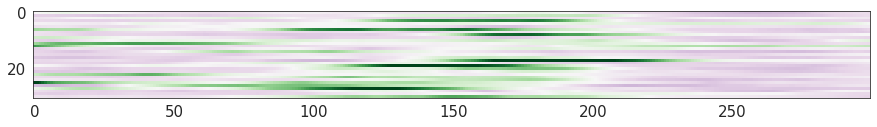

In [14]:
#genes that are down, 5pr end
chip_diff = GapR_raffaF.smooth - GapR_raff.smooth

GapEnrich = []
foldrpkM = []
ind = []
for i, j in noTY_RNAseq.iterrows():
    try:
        if (abs(j.fullstart-j.fullend) >=1000) and (j.gal > 30):
            foldrpkM.append(j[['gal','aF','aF/gal']])
            ind.append(i)
            if j.strand == 1:
                GapEnrich.append(chip_diff[j.fullstart-2000:j.fullstart+1000].values)
            else:
                GapEnrich.append(chip_diff[j.fullstart-1000:j.fullstart+2000].values[::-1])
    except:
        print(i)

binSize = 10
out = []
errs = []
for j in range(len(GapEnrich)):
    if len(GapEnrich[j]) == 3000:
        a = []
        for i in range(0,3000,binSize):
            a.append(np.mean(GapEnrich[j][i:i+10]))
        out.append(a)
    else:
        print(j)
        errs.append(j)
        
newMat = pd.DataFrame(foldrpkM)
for i in range(len(errs)):
    newMat = newMat.drop(foldrpkM[errs[i]].name)
newMat['thrends'] = out
newMat.sort_values('aF/gal',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)

plt.figure(figsize = [15,10])
plt.imshow(sortedGapEnrich[-31:],vmin=-0.15, vmax = 0.15, cmap='PRGn')

### Fig. 5C

In [15]:
#reindex (remove 1st base) to match lengths w/MNase data
new_gapR_enrich = chip_fold.copy()
for c in ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']:
    chrom = 'chr'+c
    l = new_gapR_enrich[new_gapR_enrich.chr==chrom].iloc[0].name
    new_gapR_enrich.drop(l,inplace=True)

#index positions to drop rDNA:
rDNA = mnase[(mnase.chr=='chrXII') & (mnase.pos > 448314) & (mnase.pos < 493883)].index

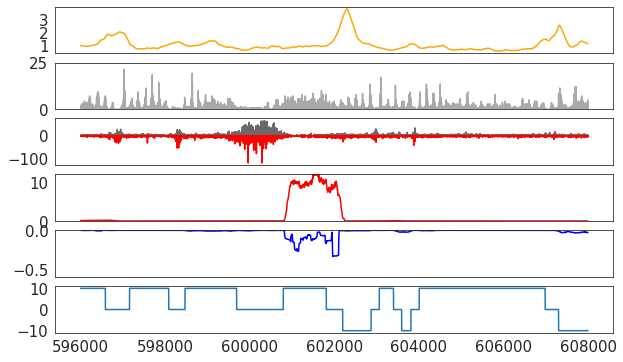

In [16]:
chrom = 'chrIV'
start = 596000
end = 608000
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),new_gapR_enrich[new_gapR_enrich.chr==chrom].fold_nolog[start:end], 'orange')
axes[1].plot(np.arange(start, end),mnase[mnase.chr==chrom].val[start:end], 'darkgrey')
axes[2].plot(np.arange(start, end),DNase_Zhong_pl[chip_fold.chr==chrom].value[start:end],'dimgrey')
axes[2].plot(np.arange(start, end),-DNase_Zhong_min[chip_fold.chr==chrom].value[start:end],'red')
axes[3].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'red')
axes[4].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')

axes[1].set_ylim([0,25])
axes[3].set_ylim([0,12])
axes[4].set_ylim([-0.6,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)

axes[5].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 5D

In [17]:
top5pct = enrichedRegions(chip_fold.fold_nolog,1.65722) #top 5 pct of positions len(chip_fold[chip_fold.fold_nolog > 2.38255])/len(chip_fold)

chip_diff = chip_fold.fold_nolog
out = []
regions = top5pct
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m+1/3*s)] #this is mean + 1/3 std
    j = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
print(len(out))
#merge GapR ChIPs
regions = sorted(list(set(out)))

out = []
i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150:  #merge within 150 bp
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
print(len(out))
GapR_peaks = out

#check if any GapR_peaks are close to chr ends, exclude them
lengths = []
for i in la.items():
    lengths.append(i[1])
    
GapR_checked = []
for i in GapR_peaks:
    start = np.min(i)
    end = np.max(i)
    append = True
    if start - 1000 <= 0:
        append=False
    else:
        for j in lengths:
            if abs(start - j) <= 1000:
                append=False
            if abs(end - j) <= 1000:
                append=False
                print(i)
    if append == True:
        GapR_checked.append(i)   

2339
1922
[1039506, 1042449]
[1042700, 1044341]
[1357880, 1359064]
[1359513, 1360775]
[6577926, 6578748]
[10031233, 10032568]


In [18]:
start = []
end = []
gmax = []
for peaks in GapR_checked[:-1]:
    start.append(peaks[0])
    end.append(peaks[1])
    gmax.append(chip_fold.fold_nolog[peaks[0]:peaks[1]].idxmax())
    
GapR_peakdf = pd.DataFrame([start,end,gmax],['start','end','max_pos']).transpose()

#remove rDNA from GapR_peakdf:
rDNA = mnase[(mnase.chr=='chrXII') & (mnase.pos > 448314) & (mnase.pos < 493883)].index
GapR_peaks_rDNA = GapR_peakdf[(GapR_peakdf.start > rDNA[0]) & (GapR_peakdf.end < rDNA[-1])].index
GapR_peakdf.drop(GapR_peaks_rDNA, inplace=True)

In [19]:
mnase_neighboring = []
gapR_neighboring = []
i = 0
N = 500
for i,value in GapR_peakdf.iterrows():
    x = value.max_pos
    mnase_neighboring.append(mnase[(x-N):(x+N)].val.values)
    gapR_neighboring.append(np.log2(chip_fold[(x-N):(x+N)].fold_nolog.values))

mx = np.asarray(mnase_neighboring)
mz = np.mean(mx, axis = 0) #np.arcsinh
gx = np.asarray(gapR_neighboring)
gz = np.mean(gx, axis = 0)

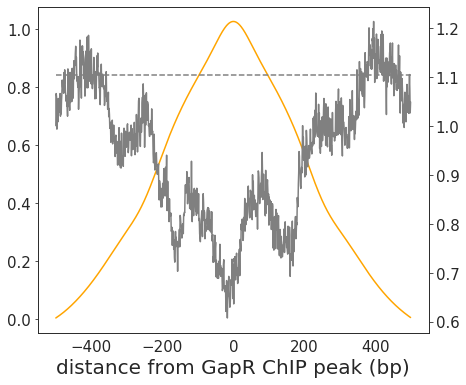

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,6),sharey=False)
axes.plot(np.arange(-N,N,1),gz,'orange')
axes.set_xlabel('distance from GapR ChIP peak (bp)', fontsize = 20)
axes.tick_params(axis='both', which='major', labelsize=15)
ax2 = axes.twinx()
ax2.plot(np.arange(-N,N,1),mz,'grey')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.plot([-N,N],[np.mean((mnase.val)),np.mean((mnase.val))],'--',c='grey')

### Fig. 5E and supplemental 1F

In [21]:
top5pct = enrichedRegions(chip_fold.fold_nolog,2.2) #500 chips

chip_diff = chip_fold.fold_nolog
out = []
regions = top5pct
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m+1/3*s)] #this is mean + 1/3 std
    j = z[1]
    start = z[0]
    end = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
print(len(out))
#merge GapR ChIPs
regions = sorted(list(set(out)))

out = []
i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #merge within 150 bp
        end = regions[i][1]
        i += 1
    else:
#        print 'no', i, regions[i][0], regions[i][1]
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
print(len(out))
GapR_peaks = out

#check if any GapR_peaks are close to chr ends, exclude them
lengths = []
for i in la.items():
    lengths.append(i[1])
    
GapR_checked = []
for i in GapR_peaks:
    start = np.min(i)
    end = np.max(i)
    append = True
    if start - 1000 <= 0:
        append=False
    else:
        for j in lengths:
            if abs(start - j) <= 1000:
                append=False
            if abs(end - j) <= 1000:
                append=False
                print(i)
    if append == True:
        GapR_checked.append(i)        
        
GapR_checked = pd.DataFrame(GapR_checked)
GapR_checked.columns = ['start','end']
len(GapR_checked[GapR_checked.end-GapR_checked.start > 50])

593
511
[1041210, 1042449]
[1042700, 1044341]
[1357880, 1359064]
[1359513, 1360775]
[6577926, 6578748]
[10031233, 10032568]


502

In [22]:
GapEnrich = []
GapEnrich2 = []
DNaseEnrich = []
rnaseq = []
ind = []
AT2 = []
N = 2000
for i, j in GapR_checked[:-1].iterrows():
    midpt = j.start+chip_fold[j.start:j.end].fold_nolog.argmax()
    GapEnrich.append(chip_fold[j.start:j.end].fold_nolog.max())
    GapEnrich2.append(chip_fold[midpt-N:midpt+N].fold_nolog.values)
    DNaseEnrich.append(DNase_Zhong_pl[midpt-N:midpt+N].both.values)
    AT2.append(100-GC(catyeastgenome[midpt-5:midpt+5]))
    ind.append(i)

binSize = 10
out = []
out2 = []
for j in range(len(DNaseEnrich)):
    a,b = [],[]
    for i in range(0,2*N,binSize):
        a.append(np.mean(DNaseEnrich[j][i:i+10]))
        b.append(np.mean(GapEnrich2[j][i:i+10]))
    out.append(a)
    out2.append(b)
    
newMat = pd.DataFrame([GapEnrich,out,ind,out2,AT2],['avGapR','DNase','orig_ind','GapR_thrends','AT']).transpose()
newMat.sort_values('avGapR',ascending=False,inplace=True)

sortedDNaseEnrich = []
sortedGapREnrich = []
for i,j in newMat.iterrows():
    sortedDNaseEnrich.append(j.DNase)
    sortedGapREnrich.append(j.GapR_thrends)

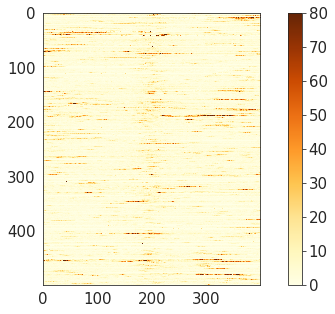

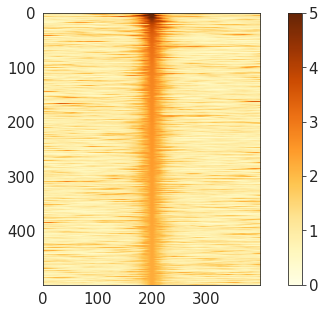

In [23]:
plt.figure(figsize = [10,5])
plt.imshow(sortedDNaseEnrich[0:500],vmin=0,vmax=80, cmap='YlOrBr')
plt.colorbar()

plt.figure(figsize = [10,5])
plt.imshow(sortedGapREnrich[0:500],vmin=0,vmax=5, cmap='YlOrBr')
plt.colorbar()

In [24]:
MNaseEnrich = []
ind = []
N = 2000
for i, j in GapR_checked[:-1].iterrows():
    midpt = j.start+chip_fold[j.start:j.end].fold_nolog.argmax()
    MNaseEnrich.append(mnase[midpt-N:midpt+N].val.values)
    ind.append(i)

binSize = 10
out = []
for j in range(len(MNaseEnrich)):
    a,b = [],[]
    for i in range(0,2*N,binSize):
        a.append(np.mean(MNaseEnrich[j][i:i+10]))
    out.append(a)
    
MNase_mat = pd.DataFrame([out,ind],['MNase','orig_ind']).transpose()
MNase_mat = newMat.merge(MNase_mat,on='orig_ind')
    
sortedMNaseEnrich = []
for i,j in MNase_mat.iterrows():
    sortedMNaseEnrich.append(j.MNase)

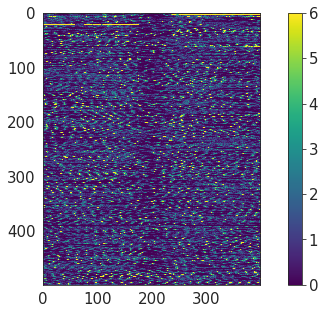

In [25]:
plt.figure(figsize = [10,5])
plt.imshow(sortedMNaseEnrich[0:500],vmin=0,vmax=6,cmap='viridis')
plt.colorbar()

### Fig. 5F

In [26]:
RNAseq_RPKM['real_start']=RNAseq_RPKM[['fullstart','fullend']].min(axis=1)
RNAseq_RPKM['real_end']=RNAseq_RPKM[['fullstart','fullend']].max(axis=1)
RNAseq_RPKM['geneL'] = RNAseq_RPKM.apply(lambda r:r['real_end']-r['real_start'],axis=1)
high_exp = RNAseq_RPKM[['name','strand','chr','real_start','real_end','geneL','gal']]
high_exp['intragenic_mean_dnase'] = high_exp.apply(lambda r:np.log10(DNase_Zhong_pl.both.loc[r['real_start']:r['real_end']]+1).mean(),axis=1)
high_exp['intragenic_mean_mnase'] = high_exp.apply(lambda r:mnase.val.loc[r['real_start']:r['real_end']].mean(),axis=1)
high_exp_final = high_exp

df_regions = pd.concat([high_exp_final,high_exp_final.shift(-1)],axis=1,keys=['left','right'],names=['gene'])
df_regions.columns = ['{}_{}'.format(x,y) for x,y in df_regions.columns]
df_regions = df_regions.dropna(subset=['right_real_start'])
df_regions=df_regions.loc[df_regions['left_chr']==df_regions['right_chr']]
df_regions.loc[df_regions['left_strand']==df_regions['right_strand'],'intergenic_type']='same'
df_regions.loc[(df_regions['left_strand']==1) & (df_regions['right_strand']==-1),'intergenic_type']='conv'
df_regions.loc[(df_regions['left_strand']==-1) & (df_regions['right_strand']==1),'intergenic_type']='div'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df_regions['intergenic_mean_mnase']=df_regions.apply(lambda r:mnase.val.loc[r['left_real_end']:r['right_real_start']].mean(),axis=1)
df_regions['intergenic_mean_dnase']=df_regions.apply(lambda r:np.log10(DNase_Zhong_pl.both.loc[r['left_real_end']:r['right_real_start']]+1).mean(),axis=1)
df_regions['intergenic_length']=df_regions.apply(lambda r:r['right_real_start']-r['left_real_end'],axis=1)
df_final = df_regions[df_regions.intergenic_length >50] #filter out things that are within 50 bases

conv 1561 Ttest_indResult(statistic=0.0, pvalue=1.0)
div 1604 Ttest_indResult(statistic=-3.2712818341028216, pvalue=0.0010821024805109576)
same 2971 Ttest_indResult(statistic=-1.9646715893503728, pvalue=0.049513293414315505)
intra 6377 Ttest_indResult(statistic=-8.604574172144691, pvalue=9.136281662918414e-18)


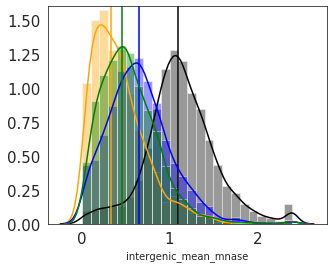

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(0,2.5,0.1)
sns.distplot(high_exp_final['intragenic_mean_mnase'].clip(bins[0],bins[-1]),bins=bins,color='black')
kde = stats.gaussian_kde(high_exp_final['intragenic_mean_mnase'])
xs = np.linspace(-0.3, 6, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,3],'-',color='black')

colors={'same':'green','div':'blue','conv':'orange'}
for i,g in df_final.groupby('intergenic_type'):
    sns.distplot(g['intergenic_mean_mnase'].clip(bins[0],bins[-1]),bins=bins,color=colors[i],label=i)
    print(i,len(g),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_mnase,g.intergenic_mean_mnase))
    kde = stats.gaussian_kde(g['intergenic_mean_mnase'])
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,3],'-',color=colors[i])

plt.ylim([0,1.6])
print('intra',len(high_exp_final),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_mnase,high_exp_final.intragenic_mean_mnase))

conv 1561 Ttest_indResult(statistic=0.0, pvalue=1.0)
div 1604 Ttest_indResult(statistic=-22.197271425717485, pvalue=1.417661279021105e-101)
same 2971 Ttest_indResult(statistic=-22.715210655487322, pvalue=2.8763686035572433e-108)
intra 6377 Ttest_indResult(statistic=22.162610625423287, pvalue=1.2031875991955065e-105)


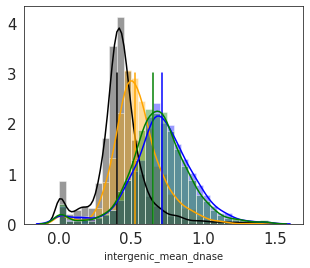

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(0,1.5,0.05)
sns.distplot(high_exp_final['intragenic_mean_dnase'].clip(bins[0],bins[-1]),bins=bins,color='black')
kde = stats.gaussian_kde(high_exp_final['intragenic_mean_dnase'])
xs = np.linspace(-0.3, 6, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,3],'-',color='black')

colors={'same':'green','div':'blue','conv':'orange'}
for i,g in df_final.groupby('intergenic_type'):
    sns.distplot(g['intergenic_mean_dnase'].clip(bins[0],bins[-1]),bins=bins,color=colors[i],label=i)
    print(i,len(g),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_dnase,g.intergenic_mean_dnase))
    kde = stats.gaussian_kde(g['intergenic_mean_dnase'])
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,3],'-',color=colors[i])

print('intra',len(high_exp_final),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_dnase,high_exp_final.intragenic_mean_dnase))

### Fig. 5 - supplemental figure 1A

(0.89373611710019, 0.0)

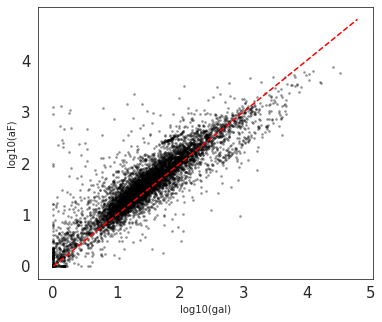

In [30]:
plt.figure(figsize=(6,5))
plt.scatter(np.log10(RNAseq_RPKM.gal+1),np.log10(RNAseq_RPKM.aF+1), marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.plot([0,4.8],[0,4.8],'--',c='red')
plt.yticks([0,1,2,3,4],size = 15)
plt.xlabel('log10(gal)')
plt.ylabel('log10(aF)')
stats.pearsonr(np.log10(RNAseq_RPKM.gal+1),np.log10(RNAseq_RPKM.aF+1))

### Fig. 5 - supplemental figure 1B

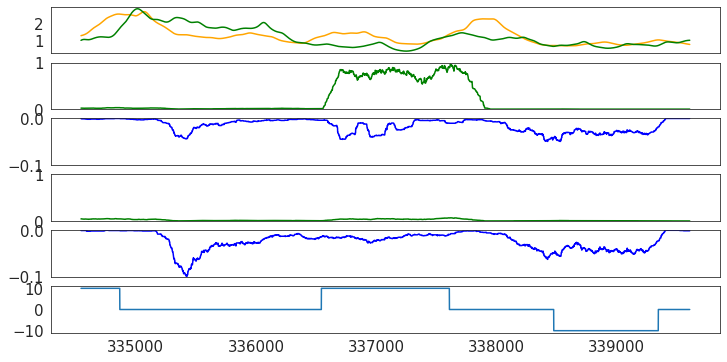

In [31]:
#YGP1, decreased in aF
start = 336544-2000
end = 337609+2000
chrom = 'chrXIV'
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12,6), sharey=False)
axes[0].plot(np.arange(start, end),chip_fold[chip_fold.chr==chrom].fold_nolog[start:end], 'orange')
axes[0].plot(np.arange(start, end),chip_foldaF[chip_foldaF.chr==chrom].fold_nolog[start:end], 'green')

axes[1].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'green')
axes[2].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')

axes[1].set_ylim([0,1])
axes[2].set_ylim([-0.1,0])

axes[3].plot(np.arange(start, end),(RNAseqaF[RNAseqaF.chr==chrom].fwd[start:end]),'green')
axes[4].plot(np.arange(start, end),-(RNAseqaF[RNAseqaF.chr==chrom].rev[start:end]),'blue')

axes[3].set_ylim([0,1])
axes[4].set_ylim([-0.1,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)

axes[5].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 5 - supplemental figure 1C

In [32]:
#drop things that are too close to chr ends
la = {}
for chrom in genomedict.keys():
    la[chrom] = GapR_raff[GapR_raff.chr==chrom].iloc[0].name

N=500
RNAseq_new = noTY_RNAseq.copy()
for c in ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']:
    chrom = 'chr'+c
    l = len(genomefasta[chrom].seq)
    e = noTY_RNAseq[noTY_RNAseq.chr == chrom].iloc[-1]
    if (l - np.max([e.end,e.start])) < N:
        RNAseq_new.drop(index = e.name,inplace=True)
    e = noTY_RNAseq[noTY_RNAseq.chr == chrom].iloc[0]
    if (np.min([e.fullend,e.fullstart]) - la[chrom]) < N:
        RNAseq_new.drop(index = e.name,inplace=True)

In [33]:
N = 500
geneL = 100
plus = RNAseq_new[(RNAseq_new.strand == 1) & (abs(RNAseq_new.end-RNAseq_new.start) >= geneL)]
minus = RNAseq_new[(RNAseq_new.strand == -1) & (abs(RNAseq_new.end-RNAseq_new.start) >= geneL)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.fullend >= values.fullend) & (minus.fullend <= values.fullend+N)])
    if len(x) != 0:
        t.append(x)

minus_new = minus.copy()
for x in t:
    try:
        minus_new.drop(index = x.index,inplace=True)
    except:
        pass

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.fullstart) & (plus.start <= values.fullstart+N)])
    if len(x) != 0:
        t2.append(x)
        
plus_new = plus.copy()
for x in t2:
    try:
        plus_new.drop(index = x.index,inplace=True)
    except:
        pass

len(minus), len(minus_new), len(plus), len(plus_new)

(2975, 1636, 3006, 2615)

Ttest_indResult(statistic=4.780500132521822, pvalue=3.0373112994099463e-06)

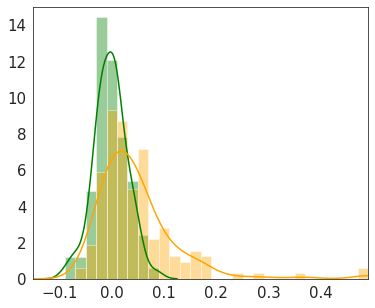

In [34]:
rpkm = 30
foldch = 2

threepr_gapR_mean_up = []
threepr_gapR_mean_dwn = []

N = 500

for index,values in plus[(np.log2((plus.aF+1)/(plus.gal+1)) >= foldch) & (plus.aF >= rpkm)].iterrows():
    end = int(values.fullend)
    threepr_gapR_mean_up.append(np.mean(GapR_raffaF[end:end+N].smooth.values-GapR_raff[end:end+N].smooth.values))
    
for index,values in minus_new[(np.log2((minus_new.aF+1)/(minus_new.gal+1)) >= foldch) & (minus_new.aF >= rpkm)].iterrows():
    end = int(values.fullend)
    threepr_gapR_mean_up.append(np.mean(GapR_raffaF[end-N:end].smooth.values-GapR_raff[end-N:end].smooth.values))

for index,values in plus[(np.log2((plus.gal+1)/(plus.aF+1)) >= foldch) & (plus.gal >= rpkm)].iterrows():
    end = int(values.fullend)
    threepr_gapR_mean_dwn.append(np.mean(GapR_raffaF[end:end+N].smooth.values-GapR_raff[end:end+N].smooth.values))
    
for index,values in minus_new[(np.log2((minus_new.gal+1)/(minus_new.aF+1)) >= foldch) & (minus_new.gal >= rpkm)].iterrows():
    end = int(values.fullend)
    threepr_gapR_mean_dwn.append(np.mean(GapR_raffaF[end-N:end].smooth.values-GapR_raff[end-N:end].smooth.values))
    
#makes the plot
plt.figure(figsize=[6,5])
bins = np.arange(-0.15,0.5,0.02)
sns.distplot(np.clip(threepr_gapR_mean_dwn,bins[0],bins[-1]),bins=bins,color='green')
sns.distplot(np.clip(threepr_gapR_mean_up,bins[0],bins[-1]),bins=bins,color='orange')
plt.xlim([bins[0],bins[-1]])
plt.ylim([0,15])
stats.ttest_ind(threepr_gapR_mean_up,threepr_gapR_mean_dwn)

Ttest_indResult(statistic=-3.8444954890470546, pvalue=0.00014967618190336434)

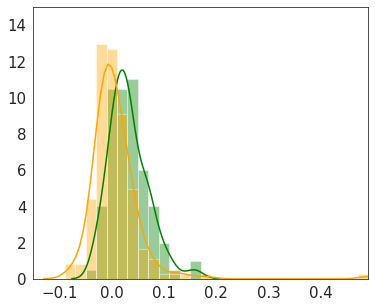

In [35]:
rpkm = 30
foldch = 2

fivepr_gapR_mean_up = []
fivepr_gapR_mean_dwn = []

N = 500

for index,values in plus_new[(np.log2((plus_new.aF+1)/(plus_new.gal+1)) >= foldch) & (plus_new.aF >= rpkm)].iterrows():
    start = int(values.fullstart)
    fivepr_gapR_mean_up.append(np.mean(GapR_raffaF[start-N:start].smooth.values-GapR_raff[start-N:start].smooth.values))
    
for index,values in minus[(np.log2((minus.aF+1)/(minus.gal+1)) >= foldch) & (minus.aF >= rpkm)].iterrows():
    start = int(values.fullstart)
    fivepr_gapR_mean_up.append(np.mean(GapR_raffaF[start:start+N].smooth.values-GapR_raff[start:start+N].smooth.values))
    
for index,values in plus_new[(np.log2((plus_new.gal+1)/(plus_new.aF+1)) >= foldch) & (plus_new.gal >= rpkm)].iterrows():
    start = int(values.fullstart)
    fivepr_gapR_mean_dwn.append(np.mean(GapR_raffaF[start-N:start].smooth.values-GapR_raff[start-N:start].smooth.values))
    
for index,values in minus[(np.log2((minus.gal+1)/(minus.aF+1)) >= foldch) & (minus.gal >= rpkm)].iterrows():
    start = int(values.fullstart)
    fivepr_gapR_mean_dwn.append(np.mean(GapR_raffaF[start:start+N].smooth.values-GapR_raff[start:start+N].smooth.values))

    
#makes the plot
plt.figure(figsize=[6,5])
bins = np.arange(-0.15,0.5,0.02)
sns.distplot(np.clip(fivepr_gapR_mean_dwn,bins[0],bins[-1]),bins=bins,color='green')
sns.distplot(np.clip(fivepr_gapR_mean_up,bins[0],bins[-1]),bins=bins,color='orange')
plt.xlim([bins[0],bins[-1]])
plt.ylim([0,15])
stats.ttest_ind(fivepr_gapR_mean_up, fivepr_gapR_mean_dwn)

### Fig. 5 - supplemental figure 1D

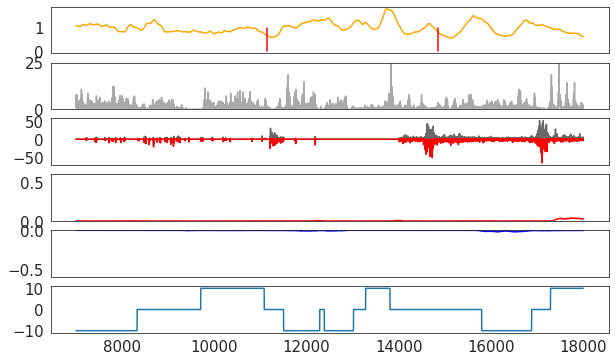

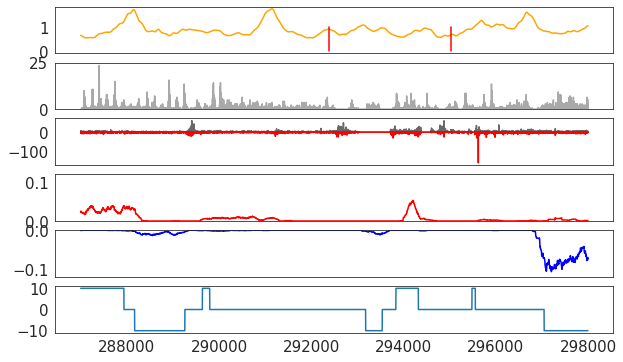

In [36]:
#HML Location: Chromosome III 11146..14849
chrom = 'chrIII'
start = 7000
end = 18000
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),new_gapR_enrich[new_gapR_enrich.chr==chrom].fold_nolog[start:end], 'orange')
axes[0].plot([11146,11146],[0,1],'red')
axes[0].plot([14849,14849],[0,1],'red')
axes[1].plot(np.arange(start, end),mnase[mnase.chr==chrom].val[start:end], 'darkgrey')
axes[2].plot(np.arange(start, end),DNase_Zhong_pl[chip_fold.chr==chrom].value[start:end],'dimgrey')
axes[2].plot(np.arange(start, end),-DNase_Zhong_min[chip_fold.chr==chrom].value[start:end],'red')
axes[3].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'red')
axes[4].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')

axes[1].set_ylim([0,25])
axes[3].set_ylim([0,0.6])
axes[4].set_ylim([-0.6,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)

axes[5].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

#HMR Location: Chromosome III 292388..295034
chrom = 'chrIII'
start = 287000
end = 298000
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),new_gapR_enrich[new_gapR_enrich.chr==chrom].fold_nolog[start:end], 'orange')
axes[0].plot([292388,292388],[0,1],'red')
axes[0].plot([295034,295034],[0,1],'red')
axes[1].plot(np.arange(start, end),mnase[mnase.chr==chrom].val[start:end], 'darkgrey')
axes[2].plot(np.arange(start, end),DNase_Zhong_pl[chip_fold.chr==chrom].value[start:end],'dimgrey')
axes[2].plot(np.arange(start, end),-DNase_Zhong_min[chip_fold.chr==chrom].value[start:end],'red')
axes[3].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'red')
axes[4].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')

axes[1].set_ylim([0,25])
axes[3].set_ylim([0,0.12])
axes[4].set_ylim([-.12,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)

axes[5].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 5 - supplemental figure 1E

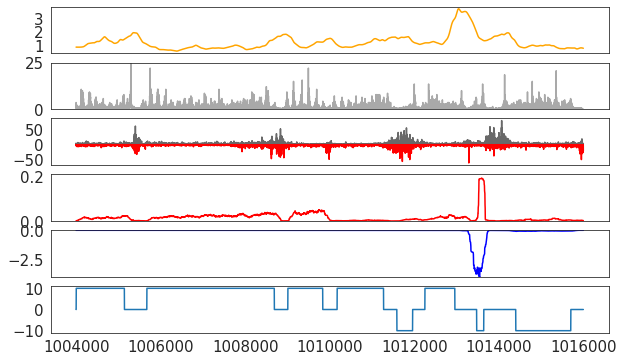

In [37]:
chrom = 'chrIV'
start = 1004000
end = 1016000
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),new_gapR_enrich[new_gapR_enrich.chr==chrom].fold_nolog[start:end], 'orange')
axes[1].plot(np.arange(start, end),mnase[mnase.chr==chrom].val[start:end], 'darkgrey')
axes[2].plot(np.arange(start, end),DNase_Zhong_pl[chip_fold.chr==chrom].value[start:end],'dimgrey')
axes[2].plot(np.arange(start, end),-DNase_Zhong_min[chip_fold.chr==chrom].value[start:end],'red')
axes[3].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'red')
axes[4].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')

axes[1].set_ylim([0,25])
axes[3].set_ylim([0,0.21])
axes[4].set_ylim([-4,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)

axes[5].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 5 - supplemental figure 1G and 1H

In [38]:
top5pctDNase = enrichedRegions(DNase_Zhong_pl.both,50) #this is top ~500 positions

out = []
regions = top5pctDNase
m = np.mean(DNase_Zhong_pl.both)
s = np.std(DNase_Zhong_pl.both)
chip_diff = DNase_Zhong_pl.both

for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-5000:z[1]+5000]
    c_diff = c[c>(m+1/3*s)] #this is mean + 1/3 std
    j = z[1]
    start = z[0]
    end = z[1]
    while j < z[1]+5000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+5000
    j = z[0]
    while j > z[0]-5000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-5000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
print(len(out))
regions = sorted(list(set(out)))

out = []
i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 10: #merge within 10 bps
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
print(len(out))
DNase_peaks = out

#check if any GapR_peaks are close to chr ends, exclude them
lengths = []
for i in la.items():
    lengths.append(i[1])
    
DNase_checked = []
for i in DNase_peaks:
    start = np.min(i)
    end = np.max(i)
    append = True
    if start - 1000 <= 0:
        append=False
    else:
        for j in lengths:
            if abs(start - j) <= 1000:
                append=False
            if abs(end - j) <= 1000:
                append=False
#                print(i)
    if append == True:
        DNase_checked.append(i)   
        
DNase_checked = pd.DataFrame(DNase_checked)
DNase_checked.columns = ['start','end']
len(DNase_checked[DNase_checked.end-DNase_checked.start > 50])

24403
9647


521

In [39]:
GapEnrich = []
DNaseEnrich = []
DNaseEnrich2 = []
rnaseq = []
ind = []
AT = []
N = 2000
for i, j in DNase_checked[DNase_checked.end-DNase_checked.start > 50].iterrows():
    midpt = j.start+DNase_Zhong_pl[j.start:j.end].both.argmax()
    GapEnrich.append(chip_fold[midpt-N:midpt+N].fold_nolog.values)
    DNaseEnrich.append(DNase_Zhong_pl[j.start:j.end].both.max())
    DNaseEnrich2.append(DNase_Zhong_pl[midpt-N:midpt+N].both.values)
#    AT.append(100-GC(catyeastgenome[j.start:j.end]))
    AT.append(100-GC(catyeastgenome[midpt-5:midpt+5]))
    ind.append(i)

binSize = 10
out = []
out2 = []
for j in range(len(GapEnrich)):
    a,b = [],[]
    for i in range(0,2*N,binSize):
        a.append(np.mean(GapEnrich[j][i:i+10]))
        b.append(np.mean(DNaseEnrich2[j][i:i+10]))
    out.append(a)
    out2.append(b)
    
newMat = pd.DataFrame([DNaseEnrich,out,ind,out2,AT],['avDNase','thrends','orig_ind','DNase_thrends','AT']).transpose()
newMat.sort_values('avDNase',ascending=False,inplace=True)

sortedGapEnrich = []
sortedDNaseEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)
    sortedDNaseEnrich.append(j.DNase_thrends)

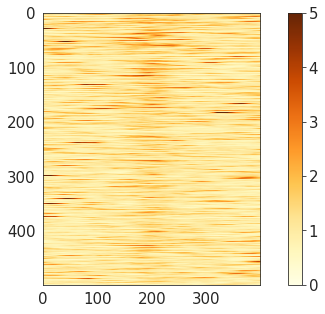

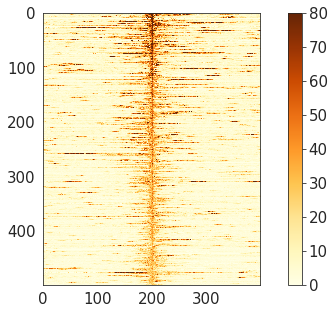

In [40]:
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[0:500],vmin = 0, vmax = 5, cmap='YlOrBr')
plt.colorbar()

plt.figure(figsize = [10,5])
plt.imshow(sortedDNaseEnrich[0:500], vmax=80, cmap='YlOrBr')
plt.colorbar()

mean %AT= 56.78 , std = 17.602033973379324


/home/msguo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


([<matplotlib.axis.XTick at 0x7f116246a780>,
 <a list of 2 Text xticklabel objects>)

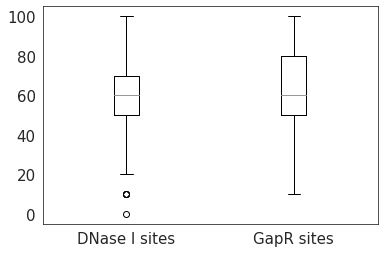

In [41]:
print('mean %AT=',np.mean(newMat[0:500].AT),', std =',np.std(newMat[0:500].AT))
plt.boxplot([newMat[0:500].AT,AT2])
plt.xticks([1,2],['DNase I sites','GapR sites'])

### Fig. 5 - supplemental figure 1I

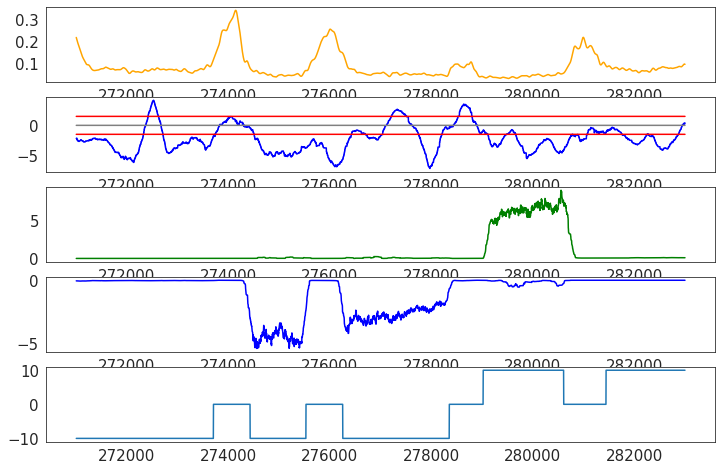

In [42]:
#log2 threshold = 1.5 (equal and greater than 1.5 are labelled as enriched regions
start = 271000
end = 283000
chrom = 'chrII'
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,8), sharey=False)
axes[0].plot(np.arange(start, end),GapR_raff[GapR_raff.chr==chrom]['val_norm_no12'][start:end],'orange')
axes[1].plot(np.arange(start, end),psoralenG128[psoralenG128.chr==chrom]['value'][start:end], 'blue')
axes[1].plot(np.arange(start, end),np.arange(start,end)*0, 'grey')
axes[1].plot(np.arange(start, end),np.arange(start,end)*0+1.5, 'r')
axes[1].plot(np.arange(start, end),np.arange(start,end)*0-1.5, 'r')
axes[2].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'green')
axes[3].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')
axes[4].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 5 - supplemental 1J

In [43]:
rDNA = GapR_raff[(GapR_raff.chr=='chrXII') & (GapR_raff.pos > 448314) & (GapR_raff.pos < 493883)].index
rep1 = GapR_raffaF.drop(index=rDNA) #drop rDNA loci from chrXII
rep2 = psoralenG128.drop(index=rDNA) #drop rDNA loci from chrXII
rep1['cumsums'] = rep1.val_norm_no12.cumsum()
rep2['cumsums'] = rep2.value.cumsum()

In [44]:
#bin data
N = 100
avgapR_rep1 = []
avgapR_rep2 = []
for x in np.arange(0,len(rep1),N):
    try:
        avgapR_rep1.append((rep1.iloc[x+N].cumsums-rep1.iloc[x].cumsums)/N)
        avgapR_rep2.append((rep2.iloc[x+N].cumsums-rep2.iloc[x].cumsums)/N)
    except:
        avgapR_rep1.append((rep1.iloc[len(rep1)-1].cumsums-rep1.iloc[x].cumsums)/N)
        avgapR_rep2.append((rep2.iloc[len(rep1)-1].cumsums-rep2.iloc[x].cumsums)/N)

(0.26345128087041286, 0.0)


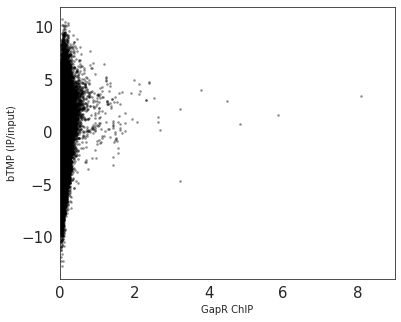

In [45]:
#Generate correlation plot
plt.figure(figsize=(6,5))
plt.scatter(avgapR_rep1,avgapR_rep2, marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.xlim([0,9])
plt.xlabel('GapR ChIP')
plt.ylabel('bTMP (IP/input)')
print(stats.pearsonr(avgapR_rep1,avgapR_rep2))